In [1]:
import scanpy as sc
import scanpy.external as sce
import tempfile
import anndata as ad
import os
import torch
import scvi
import anndata as ad
from glob import glob
import matplotlib.pyplot as plt
torch.set_float32_matmul_precision('high')
os.chdir("/data")


In [2]:
scvi.__version__

'1.2.0'

In [3]:
torch.cuda.is_available()

True

In [4]:
paths = glob("cellranger/*/qc_filtered.h5ad")
adata_list=[] #reading files
names=[]
for n in paths:
    adata = sc.read_h5ad(n)
    sample = n.split("/")[1]
    adata.obs["sample_id"]=sample
    adata.obs["condition"]=sample.split("-")[0]
    adata_list.append(adata)
    sc.pp.filter_genes(adata, min_cells=3)
    names.append(sample)

In [5]:
adata=ad.concat(adata_list, index_unique="-", keys=names) #creating one object
del adata_list
adata.layers["counts"]=adata.X.copy()

In [6]:
adata.raw = adata.copy()

In [7]:
scvi.data.poisson_gene_selection(adata, layer='counts', n_top_genes=8000, subset=True, batch_key="sample_id") # selecting HVGs using poisson sampling

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata, layer="counts", batch_key='sample_id')


In [9]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=50, n_hidden=256, gene_likelihood="zinb") #based on hptuning

In [10]:
model.train(early_stopping=True, plan_kwargs={"lr":0.002396071}, check_val_every_n_epoch=1, enable_progress_bar=True) #based on hptuning

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/miniconda3/envs/scanpy/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training:   0%|          | 0/58 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/scanpy/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
`Trainer.fit` stopped: `max_epochs=58` reached.


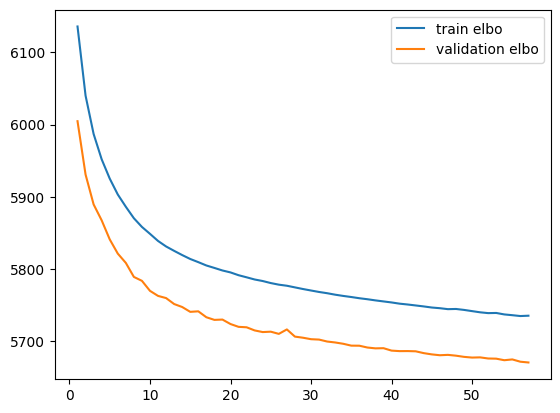

In [11]:
train_elbo = model.history['elbo_train'][1:]
validation_elbo = model.history['elbo_validation'][1:]
#ax = train_elbo.plot()
#validation_elbo.plot(ax=ax)
plt.plot(train_elbo, label="train elbo") 
plt.plot(validation_elbo, label="validation elbo") 
plt.legend()
#plt.savefig("samples_all_notcat_elbo.pdf")

In [23]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

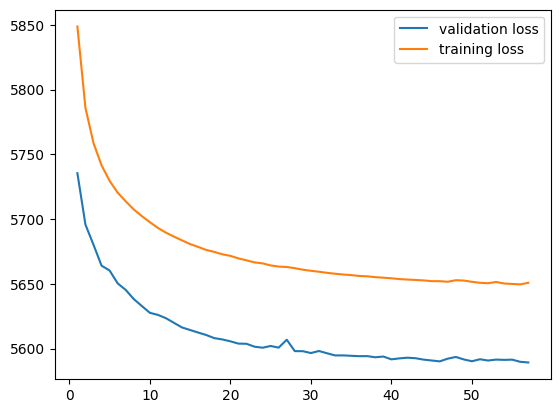

In [25]:
#plt.savefig("samples_all_notcat_elbo.pdf")
#%%
validation_lost = model.history['validation_loss'][1:]
train_loss = model.history['train_loss_epoch'][1:]
plt.plot(validation_lost, label="validation loss") 
plt.plot(train_loss, label="training loss") 
plt.legend()

In [13]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()


/home/ubuntu/miniconda3/envs/scanpy/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [14]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, n_neighbors=35)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.5)

In [15]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY], accelerator="gpu")

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              
Oct 28 08:36:16 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Oct 28 08:36:16 PM: The following items have duplicates [55949 72194 72273 72326]


In [16]:
sc.tl.umap(adata, min_dist=0.1)

In [17]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

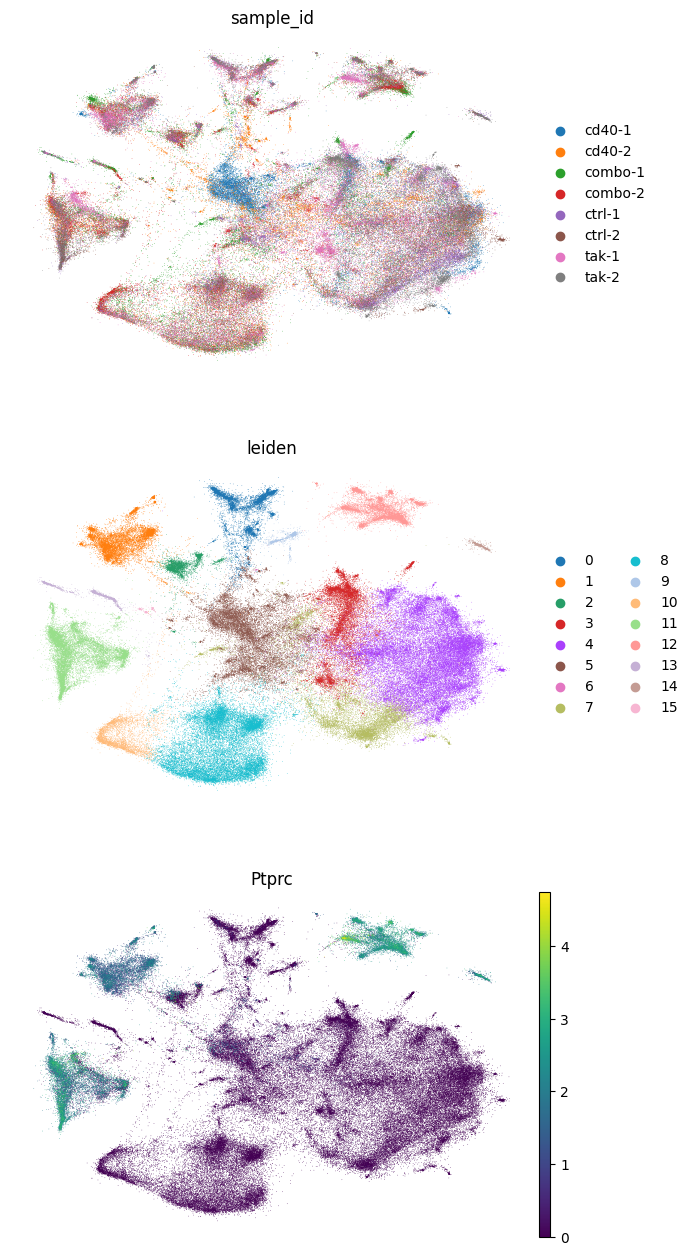

In [18]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["sample_id", "leiden", "Ptprc"],
    frameon=False,
    ncols=1,
    use_raw=False
)

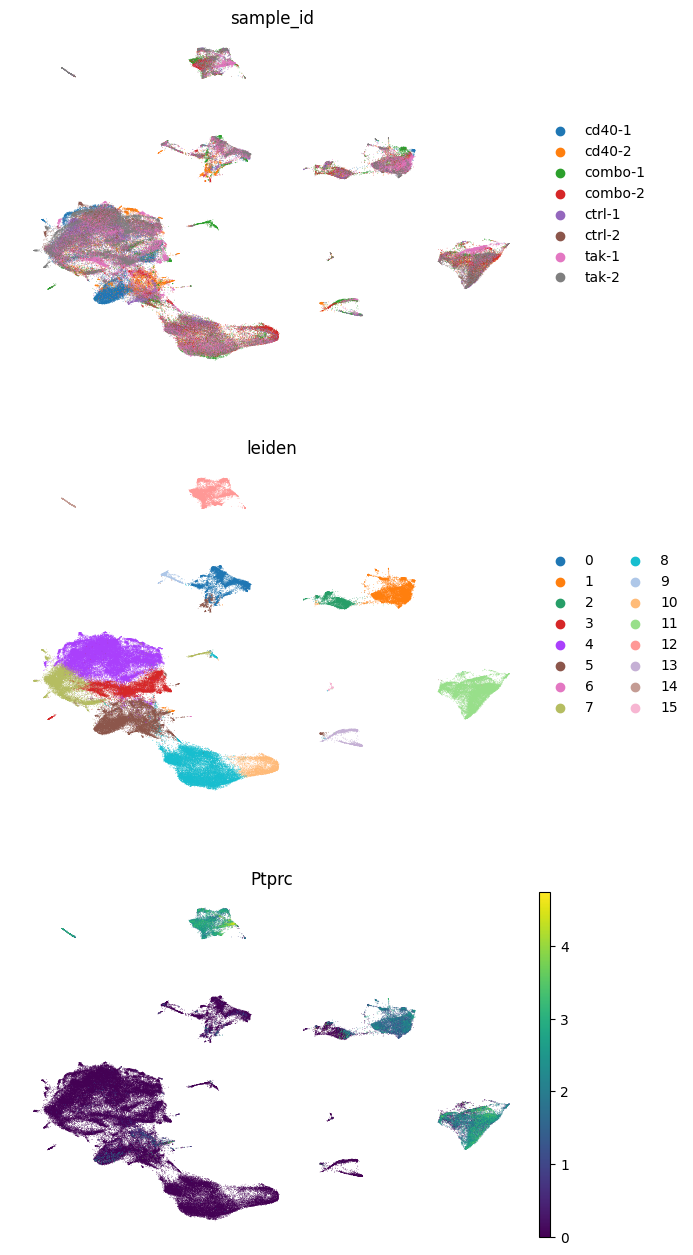

In [19]:
sc.pl.umap(
    adata,
    color=["sample_id", "leiden", "Ptprc"],
    frameon=False,
    ncols=1,
    use_raw=False
)

In [20]:
model.save("h5ad/scvi_model2")

In [21]:
adata.X = adata.layers["counts"].copy()
adata.write_h5ad("h5ad/batch_corrected.h5ad")